In [1]:
import os
import rootutils
import lightning as L
import torch
import seaborn as sns
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from torch.nn import functional as F

root = rootutils.setup_root(os.getcwd(), indicator=".project-root", pythonpath=True)

In [292]:
ckpt = torch.load(root / "logs/train/runs/2025-11-11_10-25-55/checkpoints/epoch_099.ckpt")
ckpt["hyper_parameters"]["species_list_path"] = root / "data/soundscape_vae_embeddings/smooth_nifti_vae.pt:v1/SO/UK/species.yaml"
torch.save(ckpt, root / "logs/train/runs/2025-11-11_10-25-55/checkpoints/epoch_099.ckpt")

In [2]:
from src.core.data.soundscape_vae_embeddings import SoundscapeVAEEmbeddingsDataModule
from src.core.models.species_detector import SpeciesDetector

device = 0

data_module = SoundscapeVAEEmbeddingsDataModule(
    root=root / "data/soundscape_vae_embeddings",
    model="smooth_nifti_vae",
    version="v1",
    scope="SO/UK",
)
data_module.setup(stage="eval")

model = SpeciesDetector.load_from_checkpoint(root / "logs/train/runs/2025-11-11_10-25-55/checkpoints/epoch_999.ckpt")
model, data_module

/its/home/kag25/projects/ecolistening/interpretable_bioacoustic_classifiers/.venv/lib/python3.10/site-packages/torch/utils/data/dataset.py:469: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(


(SpeciesDetector(species_list_path='/its/home/kag25/projects/ecolistening/interpretable_bioacoustic_classifiers/data/soundscape_vae_embeddings/smooth_nifti_vae.pt:v1/SO/UK/species.yaml', in_features=128, l1_penalty=0.1, penalty_multiplier=2, beta=Parameter containing:
 tensor(0., device='cuda:0'), clf_learning_rate=0.1, pool_method=<POOL.FEATURE_ATTN: 'feature_attn'>, attn_dim=10, attn_learning_rate=0.01),
 SoundscapeVAEEmbeddingsDataModule(root=PosixPath('/its/home/kag25/projects/ecolistening/interpretable_bioacoustic_classifiers/data/soundscape_vae_embeddings'), model='smooth_nifti_vae', scope='SO/UK', version='v1', train_batch_size=None, eval_batch_size=None, train_sample_size=1, eval_sample_size=1, val_prop=0.0, seed=8, num_workers=0, persist_workers=None, pin_memory=True, drop_last=False, generator=<torch._C.Generator object at 0x7f9ab6f80cf0>))

In [5]:
dl = data_module.train_dataloader()

In [6]:
model.to(device)
labels = []
y_probs = []
attn_w = []
with torch.no_grad():
    for batch in dl:
        x, y, _, y_freq = batch
        x, y = x.to(device), y.to(device)
        species_names = list(y_freq.keys())
        label_frequency = list(y_freq.values())
        A_V = torch.tanh(model.attention_V(x))
        A_U = torch.sigmoid(model.attention_U(x))
        for species_name in species_names:
            clf = model.classifiers[species_name]
            attention_w = model.attention_w[species_name]
            A = F.softmax(attention_w(A_V * A_U), dim=-2) # (N, T, 1)
            y_species_logits = clf((x * A).sum(dim=-2))
            y_species_probs = torch.sigmoid(y_species_logits)
            y_probs.append(y_species_probs)
            attn_w.append(A)
        labels.append(y)
y_probs = torch.cat(y_probs, dim=-1).mean(dim=1).cpu().numpy()
attn_w = torch.cat(attn_w, dim=-1).mean(dim=1).cpu().numpy()
labels = torch.cat(labels, dim=-1).cpu().numpy()
y_probs.shape, attn_w.shape, labels.shape

((1620, 63), (1620, 78, 63), (1620, 63))

Quick sanity check, do we have a uniform distribution of attention weights?

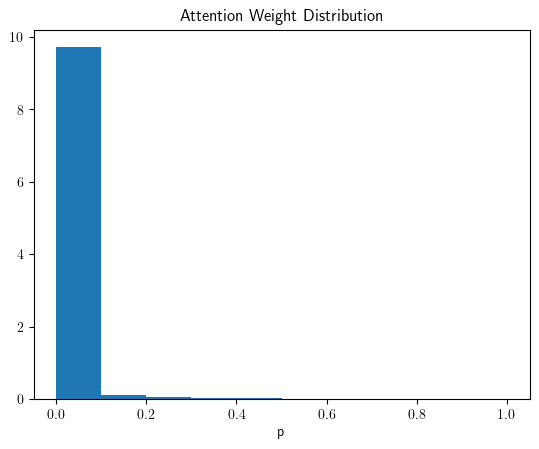

In [7]:
plt.hist(attn_w.flatten(), bins=10, density=True)
plt.title("Attention Weight Distribution")
plt.xlabel("p")
plt.show()

First trivial solution ruled out where all timesteps are equally likely to be predicted.

Second trivial solution, the model puts all attention weights onto a single timestep.

Lets look at the per-sequence entropy. Here we consider  does each sequence have some concentration of attention around a timestep?

We compare the entropy value to the log of the sequence length. If $H \to 0$ over the dataset, then we're arriving at a trivial solution where a single timestep is predicted across all data points. Similarly if $H \to \log(T)$ then we're arriving at a uniform distribution across all timesteps.

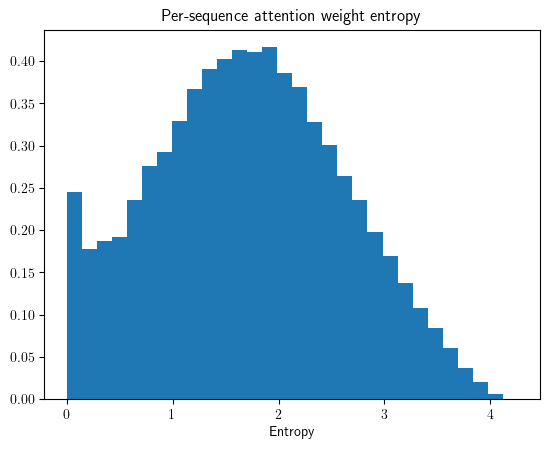

Sequence Length (T) = 78,
H_max = log(T) = 4.356708826689592
H = 1.7172675132751465 +/- 0.8909137845039368
Attention focused on 5.569289207458496 +/- 2.4373559951782227 timesteps


In [8]:
a = attn_w.transpose((0, 2, 1)).reshape(-1, attn_w.shape[1])
H = -np.sum(a * np.log(a + 1e-12), axis=1)
plt.hist(H, bins=30, density=True)
plt.xlabel("Entropy")
plt.title("Per-sequence attention weight entropy")
plt.show()
print(f"Sequence Length (T) = {a.shape[1]},")
print(f"H_max = log(T) = {np.log(a.shape[1])}")
print(f"H = {H.mean()} +/- {H.std()}")
print(f"Attention focused on {np.exp(H.mean())} +/- {np.exp(H.std())} timesteps")

It appears we have a bimodal distribution of entropies.

**Lower Mode**:
We get strong concentration around a single timestep for some seqeuences (i.e. density in the entropy bins nearest 0). This means some weights peak over a single timestep i.e. $\exp(0) = 1$, with other weights having near zero values. This could indicate:

1. Detecting a strong signal from the audio thats indicative of the class. 
2. Trivial solution for classes that don't have enough label signal to make any reasonable inference, resorting to always outputting the same timestep.

**Upper Mode**:
Most of the mass is contained in the second distribution centered around ~1.7 / 4.36. This indicates $\exp(1.7) = ~5$ timesteps are used most frequently across the seqeuence, with std deviation around that of $\exp(0.89) = ~2.44$ timesteps.

This suggests:
1. The attention weights are relatively focused on a few specific timesteps across the dataset.
2. However, we should still look at how these relate to the actual labels, and dig into that with respect to the original audio, to see if we're deriving meaningful time-step selection.

**Bear in mind** we have shifted signal, where the second half of $T$ is the same signal but shifted by half a frame, so it makes sense it would focus on a few timesteps.

We should look at whether we're getting the same timestep predicted for lots of species, in particular those rarer ones.

A simple first approach is looking at how often the maximum timestep is selected for each class. If the detector is working, we'd expect in the limit this to tend towards a uniform distribution, since when a call event occurs is arbitrary with respect to when the audio begins and ends. If the detector is failing and always selecting the same timestep, we'd see concentration around a particular timestep.

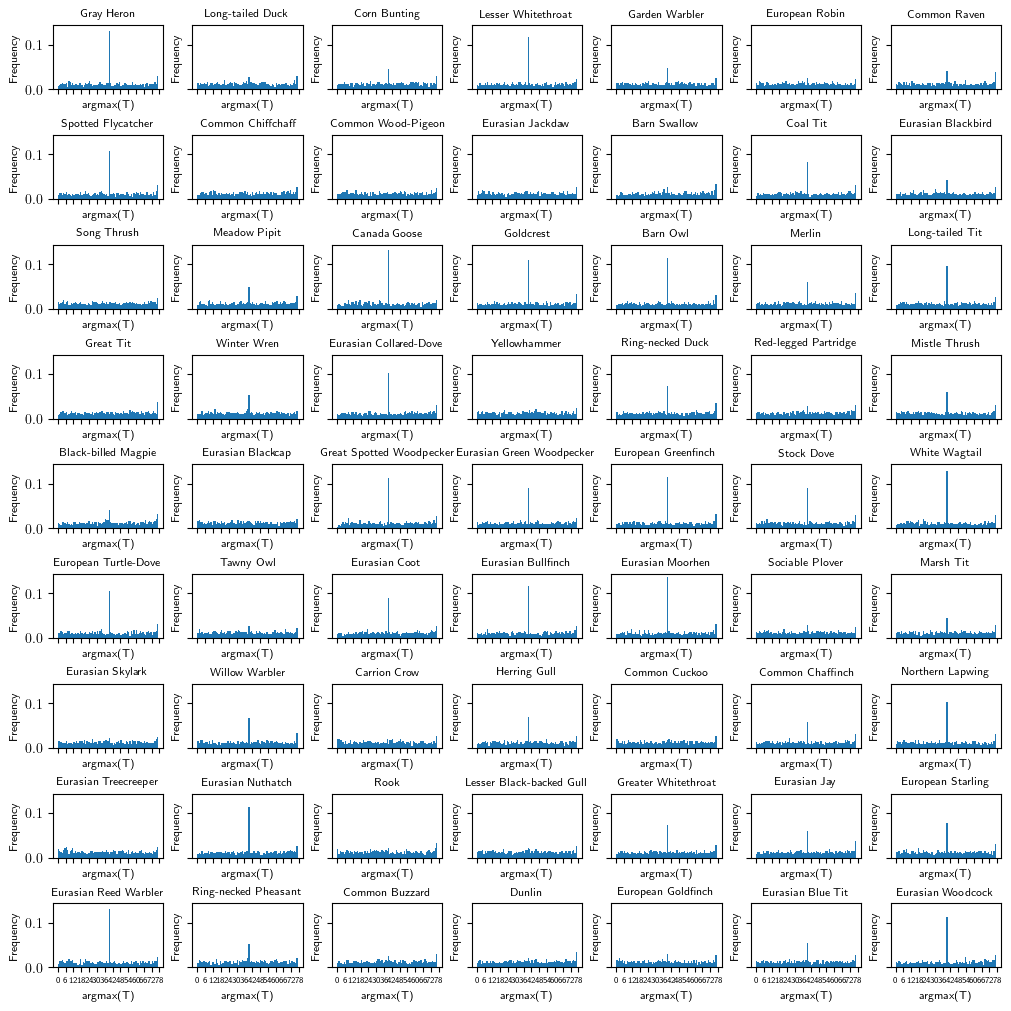

In [9]:
indices = np.argmax(attn_w, axis=1)

fig, axes = plt.subplots(nrows=indices.shape[1] // 7, ncols=7, figsize=(10, 10), sharey=True, sharex=True, constrained_layout=True)
for i, (species_name, ax) in enumerate(zip(species_names, axes.flatten())):
    ax.hist(indices[:, i], bins=range(attn_w.shape[1]), density=True)
    ax.set_title(species_name.split("_")[1], fontsize=8)
    ax.set_ylabel("Frequency", fontsize=8)
    ax.set_xlabel("argmax(T)", fontsize=8)
    ax.set_xticks(range(0, 77 + 6, 6))
    ax.set_xticklabels(range(0, 77 + 6, 6), fontsize=6)

plt.show()

This gives us a slight hint that for certain species, the same maximum timestep is selected more often than others for certain species. 

But, we note that small differences in the features will result in different outcomes, even when not related to the target (label) signal. The degree of variance here would be useful, i.e. when we positively predict a label, whats the distribution of the attention weights. Was it just luck, or did it actually focus on the relevant signal?

We can look at a measure of the degree of concentration around the maximum timestep, i.e. whats the probability the same timestep is continuously selected across all data points for each species independently. Consider only samples where the ground truth label is true.

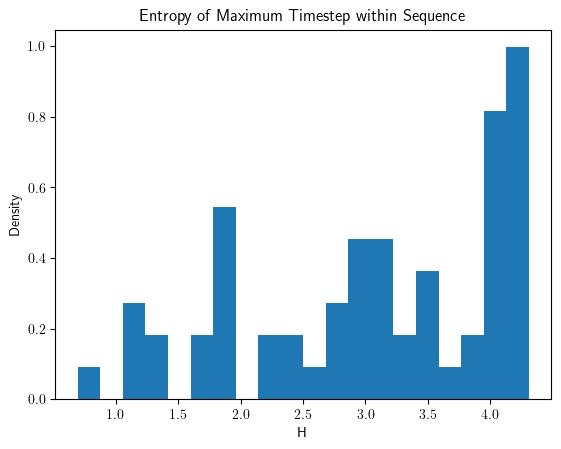

| species_name                                  |    entropy |   t_max_concentration |   train_label_frequency |
|:----------------------------------------------|-----------:|----------------------:|------------------------:|
| Erithacus rubecula_European Robin             |   4.30904  |             0.0109409 |                     739 |
| Turdus merula_Eurasian Blackbird              |   4.30585  |             0.0116737 |                     735 |
| Troglodytes hiemalis_Winter Wren              |   4.28045  |             0.0175038 |                     701 |
| Columba palumbus_Common Wood-Pigeon           |   4.27931  |             0.0177661 |                     539 |
| Turdus philomelos_Song Thrush                 |   4.27164  |             0.0195267 |                     532 |
| Phylloscopus collybita_Common Chiffchaff      |   4.257    |             0.0228862 |                     434 |
| Phasianus colchicus_Ring-necked Pheasant      |   4.25144  |             0.0241615 |          

In [10]:
T = attn_w.shape[1]
H = np.zeros(labels.shape[1])
for i in range(labels.shape[1]):
    idx,  = np.where(labels[:, i] == 1)
    if len(idx) <= 1:
        H[i] = np.nan
        continue
    indices = np.argmax(attn_w[idx, :, i], axis=1).squeeze()
    counts = np.bincount(indices, minlength=T)
    p_t = counts / counts.sum()
    H[i] = -np.sum([p * np.log(p) for p in p_t if p > 0])
plt.hist(H, density=True, bins=20)
plt.title("Entropy of Maximum Timestep within Sequence")
plt.xlabel("H")
plt.ylabel("Density")
plt.show()

# H / np.log(T) normalises between 0 and 1, since the maximum entropy is np.log(T)
# 1 - (H / np.log(T)) therefore gives us a measure of the level of concentration around selecting the same maximum timestep
df = pd.DataFrame(
    data=list(zip(species_names, H, 1 - (H / np.log(T)), data_module.train_data.dataset.y_freq.values())),
    columns=["species_name", "entropy", "t_max_concentration", "train_label_frequency"]
).set_index("species_name").sort_values(by="t_max_concentration")
print(df.to_markdown())

This is a measure of concentration around the maximum timestep across all sequences in the data. 

**Interpretation**:
- Maximum entropy of $H \approx 4.35$ indicates any timestep is equally likely to be selected as the maximum. This could indicate either model degeneracy from completely random selection, or reasonably focusing on relevant signal that is, in theory, relatively uniformly distributed.
- Low entropy $H \to 0$ indicates the same maximum timestep is always selected, indicating model degeneracy.
- Middling values for entropy suggests some degree of concentration around some timesteps over others. This could be due to model degeneracy or partial sensitivity to actual signal.

We note here that species with the highest entropy are those we perform best on in terms of auROC and mAP, while those that are very low nearly always select the same timestep, we have model degeneracy due to inadequate label signal in the training data distribution.

**But** it only considers samples where the positive label is true. So actually, this isn't a great measure, because for rarer species, only a handful of samples are considered, we don't see the full distribution. If we drop the label separation, then the results are well spread, indicating most likely random selection. But we do see that when the label is true for rarer species, it always picks the same timestep.

In [12]:
label_names = np.array(list(data_module.train_data.dataset.y_freq.keys()))
label_counts = np.array(list(data_module.train_data.dataset.y_freq.values()))
sort_idx = list(reversed(label_counts.argsort()))

Compute the attention centroid (the weighted average of timesteps across all data points) and the dispersion (i.e. the standard deviation from the centroid) to get a sense of how spread out the weights are across all timesteps.

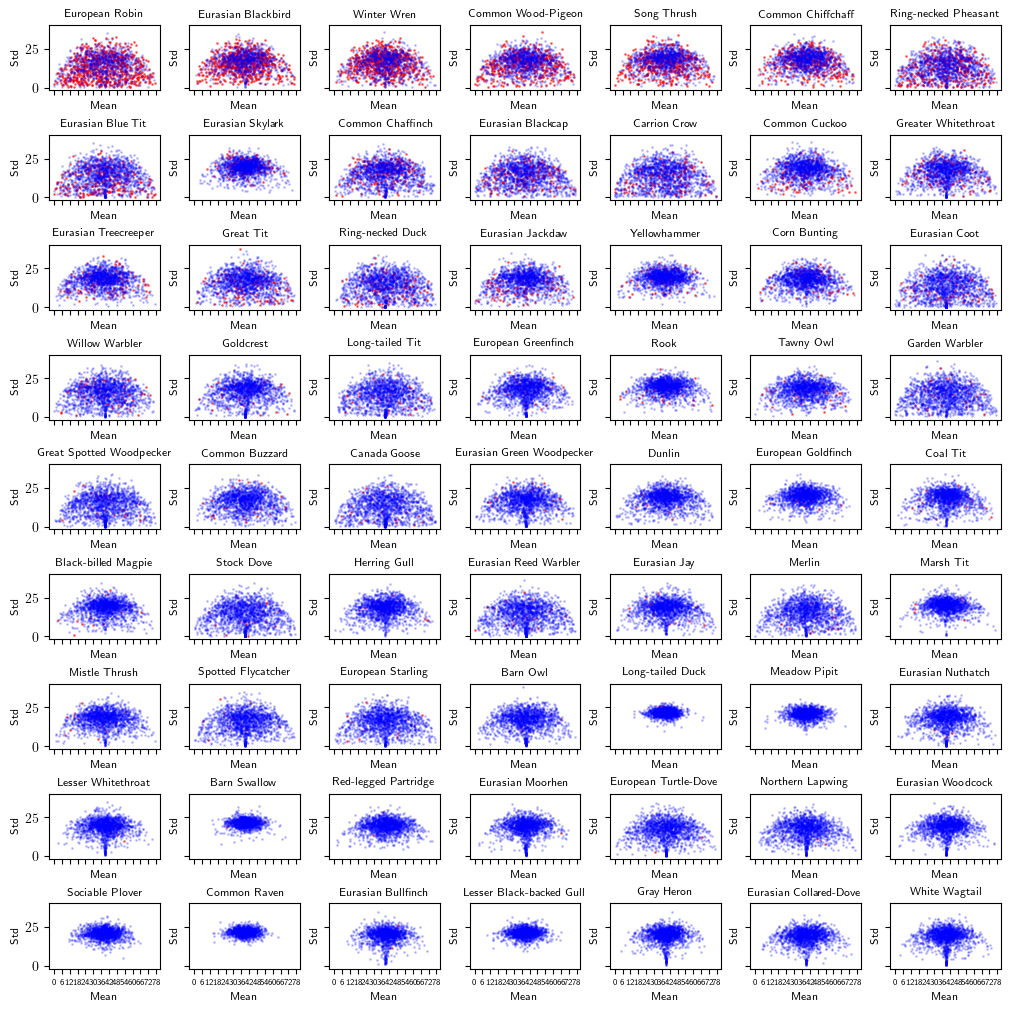

In [22]:
N, T, D = attn_w.shape

fig, axes = plt.subplots(nrows=len(label_names) // 7, ncols=7, figsize=(10, 10), sharey=True, sharex=True, constrained_layout=True)

attn_w_sorted_by_freq = attn_w[:, :, sort_idx]

for i, (label, ax) in enumerate(zip(label_names[sort_idx], axes.flatten())):
    idx, = np.where(labels[:, sort_idx][:, i] == 1)
    timesteps = np.arange(T)
    x = attn_w_sorted_by_freq[idx, :, i]
    centroid = np.dot(x, timesteps)
    variance = np.sum(x * (timesteps - centroid[:, None])**2, axis=1)
    dispersion = np.sqrt(variance)
    ax.scatter(centroid, dispersion, s=1, marker='o', color="red", alpha=0.5)
    idx, = np.where(labels[:, sort_idx][:, i] == 0)
    x = attn_w_sorted_by_freq[idx, :, i]
    # centroid is the weighted average of timesteps (Σ_i^T t_i * w_i) / Σ_i w_i
    # Σ_i w_i = 1 so its just the dot product
    mean = np.dot(x, timesteps)
    # dispersion is the standard deviation around the mean
    # subtract the mean timestep and square, then apply weights and sqrt
    std = np.sqrt(np.sum(x * (timesteps - mean[:, None])**2, axis=1))
    ax.scatter(mean, std, s=1, marker='o', alpha=0.2, color="blue")
    ax.set_title(label_names[sort_idx][i].split("_")[1], fontsize=8)
    ax.set_xlabel("Mean", fontsize=8)
    ax.set_ylabel("Std", fontsize=8)
    ax.set_xticks(range(0, 77 + 6, 6))
    ax.set_xticklabels(range(0, 77 + 6, 6), fontsize=6)

plt.show()

**Observations**:

- Species occurring regularly (top row) are regularly able to be quite certain (low variance) about a large spread of timesteps.
- For these species, as uncertainty increases, the model tends towards predicting timesteps more towards the center.
- Species occurring less frequently, some models tend towards predicting the centroid of the timesteps with high certainty, this will be a spurious prediction.
- For other rarer species there remains high uncertainty around the mean, and no certain predictions

We should analyse this in terms of correctness, i.e. when the model is making correct predictions of presence (TP/TN), how certain is it about the relevant timestep, and vice versa, (FP/FN).

This was useful for identifying degeneracy in models where labels are infrequent, but it hasn't told us much about how accurate these weightings are for identifying relevant signal, i.e. specific species calls.

Lets now dig into the actual audio signal. For each label, plot the attention weights as coloured line (white: p(t) = 0 to black: p(t) = 1) below the spectrogram for selected samples from the test set to see whether the timestep selected is relevant to the label.

First lets select some samples where there aren't many labels.

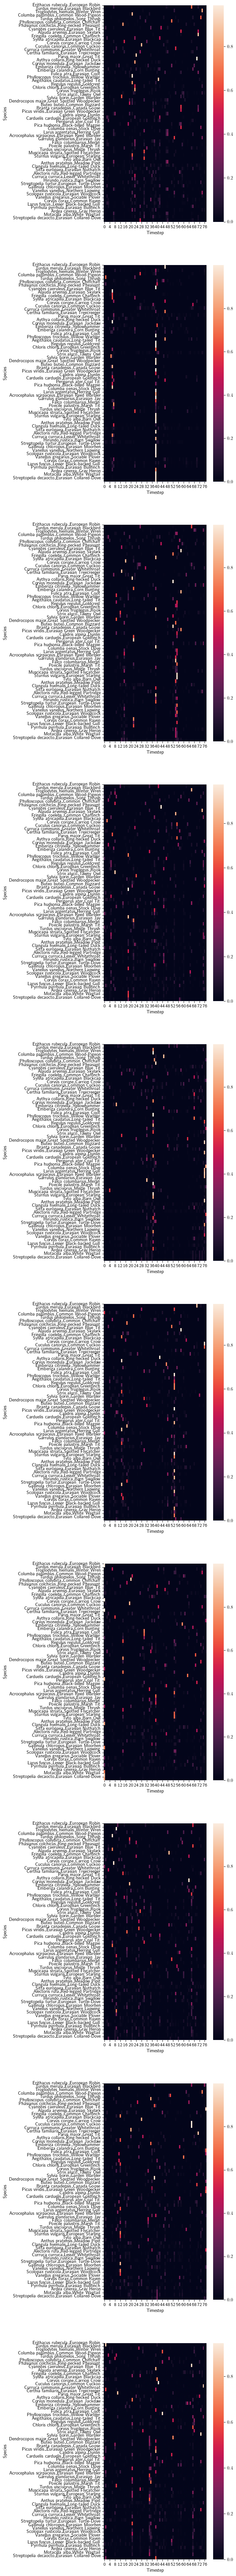

In [328]:
nrows, ncols = 10, 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5, nrows * 10))

attn_w_sorted_by_freq = attn_w[:, :, sort_idx]
for i, ax in zip(range(nrows * ncols), axes.flatten()):
    sns.heatmap(attn_w_sorted_by_freq[i].T, ax=ax)
    ax.set_xlabel("Timestep")
    ax.set_ylabel("Species")
    ax.set_yticks(range(len(label_names[sort_idx])))
    ax.set_yticklabels(label_names[sort_idx], rotation=0)
plt.show()